## Overview

This is a demo.


In [37]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import datetime as dt

# Import the QPPQ model
from QPPQModel import StreamflowGenerator


In [38]:
def remove_managed_basins(x):
    """
    Removes managed basins. Inputs must be pd.DataFrame.
    """
    labels = ["CAT_RESERVOIR", "CAT_NORM_STORAGE2013", "CAT_NID_STORAGE2013", "CAT_NDAMS2013"]
    for label in labels:
        if label in x.columns:
            managed = x.index[x[label] > 0]
            x = x.drop(managed, axis = 0)
        else:
            pass
    return x

In [10]:
# Model generation specifications
N_ENSEMBLE = 100
K = 20
start_date = '2000-01-01'
end_date = '2010-12-31'

# Constants
cms_to_mgd = 22.82
qs = [0.0003, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.995, 0.9997]


In [57]:
use_nhm_fdcs = True

### Load data 
Q = pd.read_csv('./data/historic_observed_flow.csv', sep = ',', index_col = 0, parse_dates=True)*cms_to_mgd

gauge_features = pd.read_csv(f'./data/training_inputs.csv', sep=',', index_col=0)
unmanaged_gauges = remove_managed_basins(gauge_features)
unmanaged_site_ids = list(set(unmanaged_gauges.index.to_list()))

Q = Q.loc[:, unmanaged_site_ids]

gauge_locations = pd.read_csv(f'./data/training_locations_2010_2019.csv', sep=',', index_col=0)
gauge_locations = gauge_locations.loc[gauge_locations['station'].isin(Q.columns), :]
gauge_locations.index = gauge_locations['station']
gauge_locations = gauge_locations.drop(['station'], axis=1)

nhm_fdc = pd.read_csv('./data/nhmv10_node_fdc.csv', sep =',',  index_col = 0)
prediction_locations = pd.read_csv(f'./data/prediction_locations.csv', sep = ',', index_col=0)

Q = Q.loc[:, gauge_locations.index]
Q.shape


(14610, 374)

In [58]:
## Run model predictions
model = StreamflowGenerator(K= K,
                            observed_flow = Q, 
                            observation_locations=gauge_locations,
                            probabalistic_sample = True)

In [61]:
# Specify prediction location data
node = 'wallenpaupack'
location = prediction_locations.loc[node, ['long', 'lat']].values
fdc = nhm_fdc.loc[node, :].values
datetime = pd.date_range(start_date, end_date)

# Intialize storage
QPPQ_ensemble = np.zeros((14610, N_ENSEMBLE))

for i in range(N_ENSEMBLE):
    QPPQ_ensemble[:, i] = model.predict_streamflow(location, fdc).values.flatten()

Text(0.5, 1.0, 'wallenpaupack Inflow')

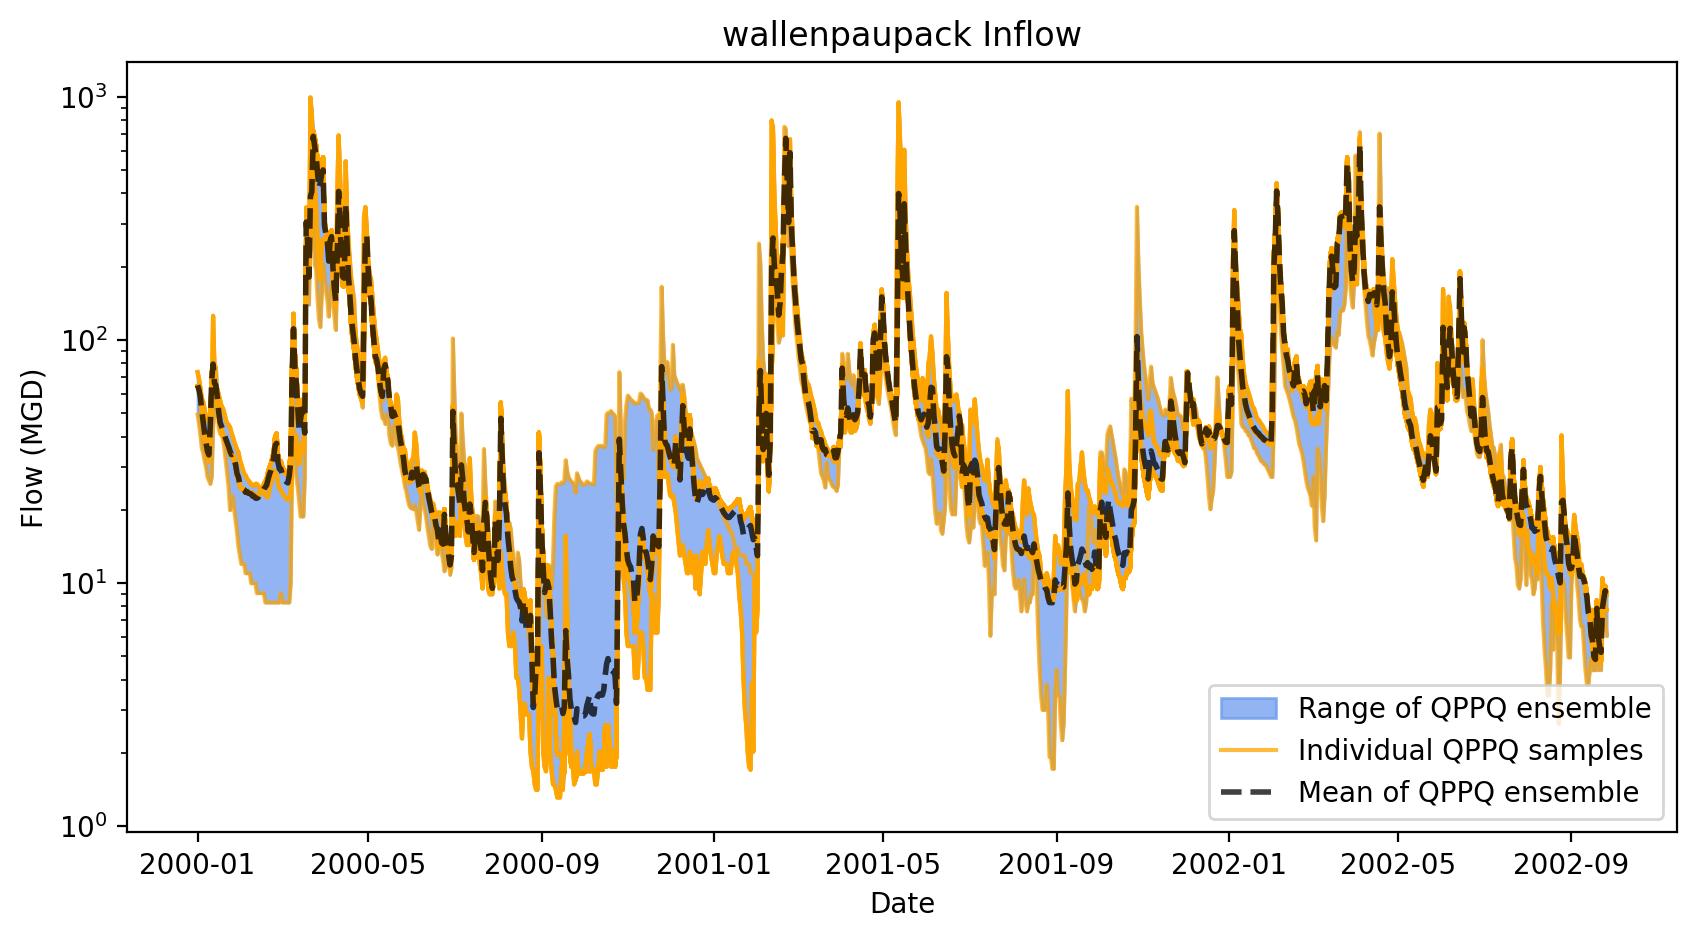

In [69]:
nt = 1000

plt.figure(figsize = (10,5), dpi = 200)

plt.fill_between(datetime[0:nt], QPPQ_ensemble[0:nt, :].min(axis=1), QPPQ_ensemble[0:nt, :].max(axis=1), 
                 color = 'cornflowerblue', alpha= 0.7,
                 label = 'Range of QPPQ ensemble')

for i in range(N_ENSEMBLE):
    if i ==0:
        plt.plot(datetime[0:nt], QPPQ_ensemble[0:nt, i], color = 'orange', alpha = 0.75, label = 'Individual QPPQ samples')
    else:
        plt.plot(datetime[0:nt], QPPQ_ensemble[0:nt, i], color = 'orange', alpha = 0.75)

plt.plot(datetime[0:nt], QPPQ_ensemble[0:nt, :].mean(axis=1), color = 'black',lw=2, alpha = 0.75, ls = 'dashed', label = 'Mean of QPPQ ensemble')

plt.ylabel('Flow (MGD)')
plt.yscale('log')
plt.xlabel('Date')
plt.legend()
plt.title(f'{node} Inflow')